In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
import seaborn as sb
import sklearn
import spacy
import re
!pip install gensim pyldavis wordcloud textblob textstat

nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [33]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [34]:
imdbDF = pd.read_csv('/content/training.csv')
imdbDF.head()

,text,sentiment
0,One of the other reviewers has mentioned that ...,0
1,A wonderful little production. <br /><br />The...,0
2,I thought this was a wonderful way to spend ti...,0
3,Basically there's a family where a little boy ...,1
4,"Petter Mattei's ""Love in the Time of Money"" is...",0


In [35]:
imdbDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       75000 non-null  object
 1   sentiment  75000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


<Axes: >

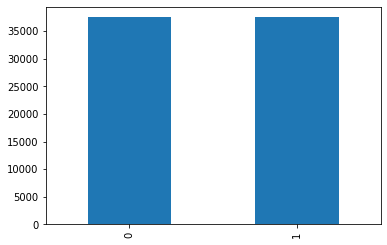

In [36]:
imdbDF['sentiment'].value_counts().plot(kind = 'bar')

From the above two outputs, we notice that there are equal number of positive and negative sentiment datapoints and no null values. Therefore, there is no need for upsampling/downsampling and null checks.

## Raw Data Analysis

<Axes: >

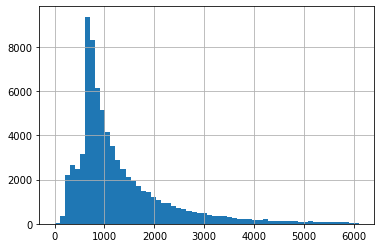

In [37]:
#Number of Characters
imdbDF['text'].str.len().hist(bins = 60, range = [0, 6100])

The above plot visualizes the number of characters in each review. This is much more than the average characters one would find in a tweet on Twitter. This is because, reviews tend to be larger with an upper limit of 10,000 characters per user review, as compared to Twitter, which has an upper limit of 4,000.

This also helps us realize that, the text might talk about different aspects across the different sentences. Therefore, one important NLP task to be considered is Aspect Recognition.

<Axes: >

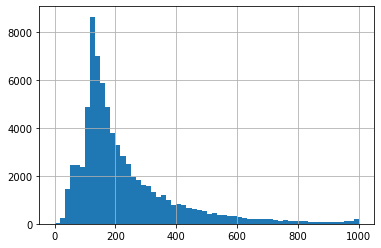

In [38]:
#Number of words
imdbDF['text'].map(lambda x: len(str(x).split()) if x else 0).hist(bins = 60, range = [0, 1000])

<Axes: >

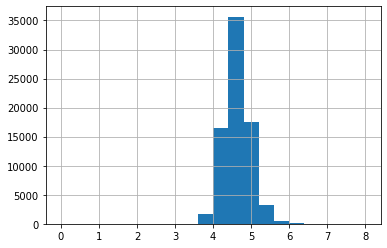

In [39]:
#Average word length
imdbDF['text'].apply(lambda x: [len(word) for word in str(x).split()]).map(lambda x: np.mean(x)).hist(bins = 20, range = [0, 8])

Based on the average word length, we note that it centers around ~5-6 characters per word. This goes to show that the dataset majorly contains simpler/shorter words; despite the longer lengths of the reviews.

## Data Cleaning

In [40]:
default_stopwords = set(nltk.corpus.stopwords.words('english'))
#excluding some useful words from stop words list as we doing sentiment analysis
excluding = set(['against','not','don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
             'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't",
             'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't",'shouldn', "shouldn't", 'wasn',
             "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"])

stopword = default_stopwords - excluding

# create a lemmatizer object
lemmatizer = WordNetLemmatizer()

### Most Common Stopwords

In [41]:
from collections import defaultdict
stopwordDict = defaultdict(int)
for sentence in imdbDF['text']:
    for word in str(sentence).split():
        if word in stopword:
            stopwordDict[word] += 1

<BarContainer object of 50 artists>

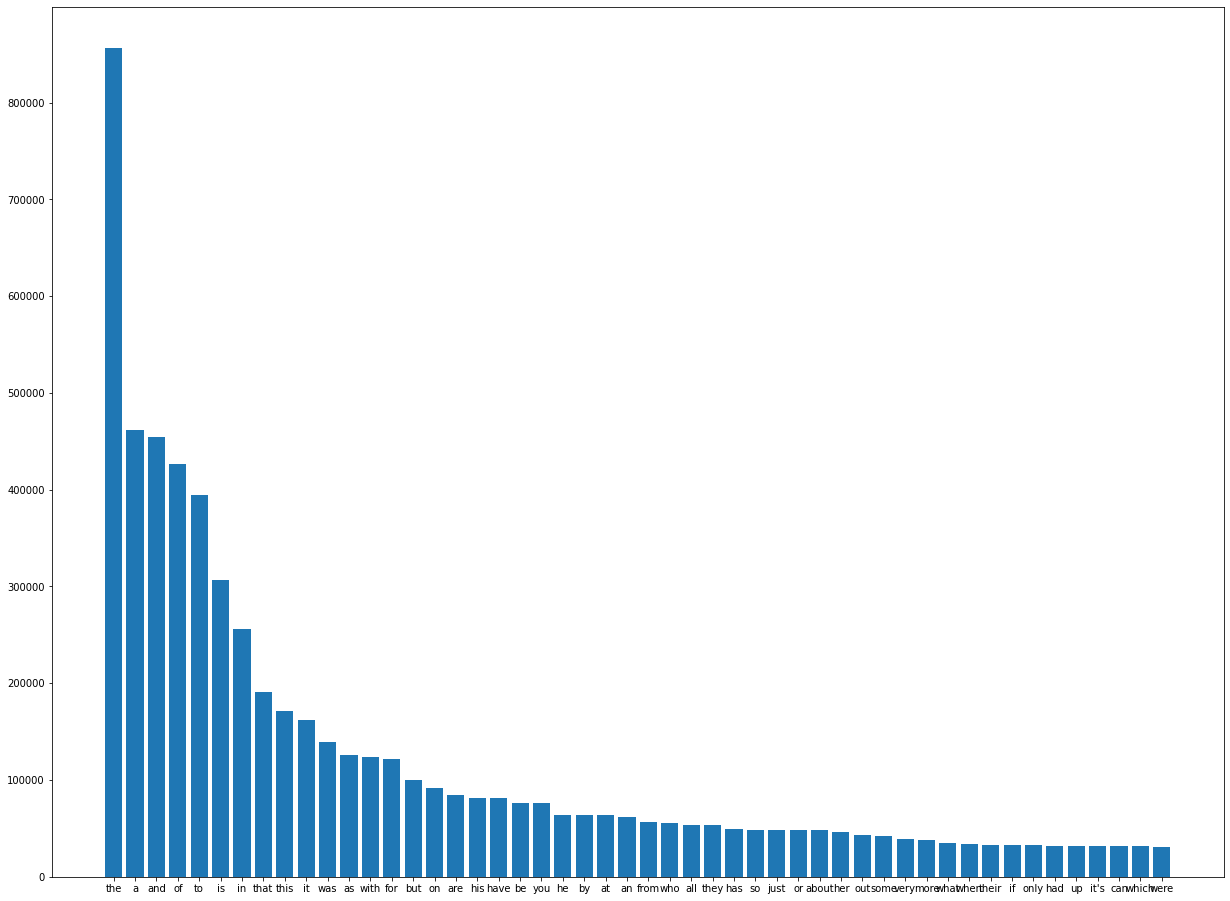

In [42]:
f, ax = plt.subplots(figsize=(21,16))
#Choosing the top 50 stopwords
topValues = {k: v for k, v in sorted(stopwordDict.items(), key=lambda item: item[1], reverse = True)[:50]}
plt.bar(topValues.keys(), topValues.values())

In [43]:
# Remove any HTML tags
def clean_html(sentence): 
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text

#Function to keep only words containing letters A-Z and a-z.
#this will remove all punctuations, special characters.
def rem_pun(sentence):
    cleaned_text  = re.sub('[^a-zA-Z]',' ',sentence)
    return (cleaned_text)

#Remove URL from sentences.
def rem_url(sen):
    txt = re.sub(r"http\S+", " ", sen)
    sen = re.sub(r"www.\S+", " ", txt)
    return (sen)

#Remove words like 'ddddddddd', 'funnnnnn', 'coolllllll' etc. Preserves words like 'goods', 'cool', 'best' etc. We will remove all such words which has three consecutive repeating characters.
def remove_extra(sen): 
    cleaned_text  = re.sub("\s*\b(?=\w*(\w)\1{2,})\w*\b",' ',sen)
    return (cleaned_text)

def remove_stopword_lemmatize(sen):
    text_tokenized = re.split('[^(A-Za-z0-9_$)]+', sen) # tokenization, remove non-words
    text_nonstop = [lemmatizer.lemmatize(word) for word in text_tokenized if word not in stopword] # remove stopwords and stemming
    return " ".join(text_nonstop)

def lower_case(x):
    x = str(x).lower()
    x = x.replace(",000,000", " m").replace(",000", " k").replace("′", "'").replace("’", "'")\
                           .replace("won't", " will not").replace("cannot", " can not").replace("can't", " can not")\
                           .replace("n't", " not").replace("what's", " what is").replace("it's", " it is")\
                           .replace("'ve", " have").replace("'m", " am").replace("'re", " are")\
                           .replace("he's", " he is").replace("she's", " she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will").replace("how's"," how has").replace("y'all"," you all")\
                           .replace("o'clock"," of the clock").replace("ne'er"," never").replace("let's"," let us")\
                           .replace("finna"," fixing to").replace("gonna"," going to").replace("gimme"," give me").replace("gotta"," got to").replace("'d"," would")\
                           .replace("daresn't"," dare not").replace("dasn't"," dare not").replace("e'er"," ever").replace("everyone's"," everyone is")\
                           .replace("'cause'"," because")
    
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    return x

The above functions have been declared to help with data cleaning, each performing one specific function. For example, removing HTML tags, URLs, and converting words to lower case.

We also do some rule based micro-text normalization above. This is done based on some commonly used microtext in reviews.

In [44]:
#Cleaning the text from dataset
def cleaned_text(review):
    review = lower_case(review)
    review = clean_html(review)
    review = rem_url(review)
    review = rem_pun(review)
    review = remove_extra(review)
    review = remove_stopword_lemmatize(review)
    return review
  
imdbDF['text']=imdbDF['text'].apply(cleaned_text)
imdbDF.head()

,text,sentiment
0,one reviewer mentioned watching oz episode hoo...,0
1,wonderful little production filming technique ...,0
2,thought wonderful way spend time hot summer we...,0
3,basically family little boy jake think zombie ...,1
4,petter mattei love time money visually stunnin...,0


As we can see above, we have completed data cleaning. This includes stopword removal, lemmatization, case folding, url removal and html tag removal. We now save this cleaned data.

In [45]:
imdbDF.to_csv('cleanedData.csv', index = False)

## Cleaned Data Analysis

<Axes: >

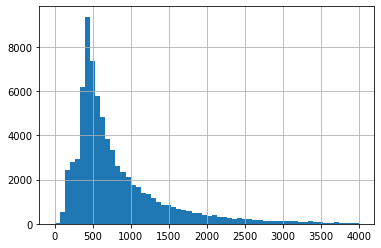

In [46]:
#Number of Characters
imdbDF['text'].str.len().hist(bins = 60, range = [0, 4000])

<Axes: >

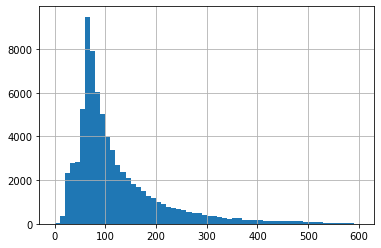

In [47]:
#Number of words
imdbDF['text'].map(lambda x: len(str(x).split()) if x else 0).hist(bins = 60, range = [0, 600])

<Axes: >

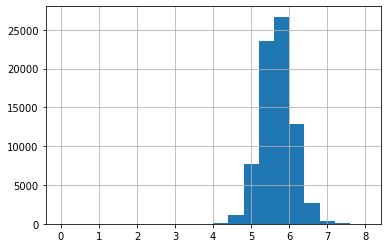

In [48]:
#Average word length
imdbDF['text'].apply(lambda x: [len(word) for word in str(x).split()]).map(lambda x: np.mean(x)).hist(bins = 20, range = [0, 8])

From the above plots, we are able to analyze that we have performed data cleaning well. The number of characters per record has drastically dropped from a median of ~1000 to ~500 characters. The median of the number of words has also dropped from ~150 to ~70 words per record.

### Word Cloud

In [49]:
#Create a corpus
corpus = set()
for sentence in imdbDF['text']:
    for word in str(sentence).split():
        corpus.add(word)

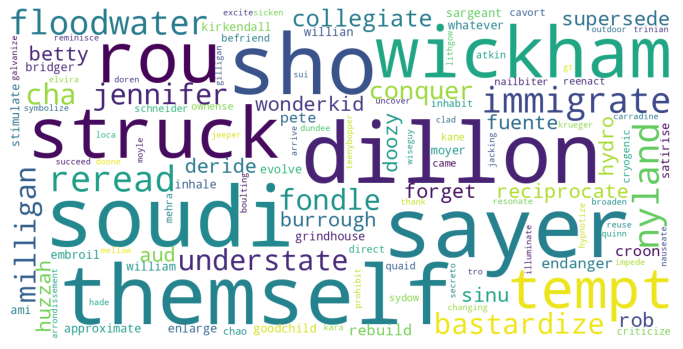

In [50]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=150,
        max_font_size=50,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(" ".join(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(list(corpus))